<a href="https://colab.research.google.com/github/PeiYauWeng/Data_sampling_for_compression/blob/main/Data_sampling_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def sampling_method(data, blocksize, sampling_type):
  data = data.flatten()
  remainder = data.size%blocksize
  if(remainder != 0):
    data = np.pad(data, (0, int(blocksize-remainder)), mode='constant', constant_values = (0,0))
  num_raw = int(data.size/blocksize)
  data = np.reshape(data, (num_raw, blocksize))
  if sampling_type is "maximum":
    ##data = np.max(data, axis=1);
    if(remainder != 0):
      data = np.concatenate((np.max(data[:-1], axis=1), np.max(data[-1, :remainder])[np.newaxis]))
    else:
      data = np.max(data, axis=1)
  if sampling_type is "minimum":
    if(remainder != 0):
      data = np.concatenate((np.min(data[:-1], axis=1), np.min(data[-1, :remainder])[np.newaxis]))
    else:
      data = np.min(data, axis=1)
  if sampling_type is "mix":
    if(remainder != 0):
      data = np.concatenate((np.concatenate((np.max(data[:-1], axis=1)[:,np.newaxis],np.min(data[:-1], axis=1)[:,np.newaxis]), axis=1),
                             np.array([np.max(data[-1, :remainder]), np.min(data[-1, :remainder])])[np.newaxis,:]), axis=0)
    else:
      data = np.concatenate((np.max(data, axis=1)[:,np.newaxis],np.min(data, axis=1)[:,np.newaxis]), axis=1)
    data = data.flatten()
  if sampling_type is "random":
    ##rest = data[-1, np.random.randint(remainder)]
    if(remainder != 0):
      data = np.concatenate((data[np.linspace(0,num_raw-2,num_raw-1).astype(int), np.random.randint(blocksize, size=(num_raw-1))],
                             data[-1, np.random.randint(remainder)][np.newaxis]))
    else:
      data = data[np.linspace(0,num_raw-1,num_raw).astype(int), np.random.randint(blocksize, size=num_raw)]
  return data 

In [ ]:
data = np.random.rand(5000,3000)*255
##print(data)
sampling_method(data, 6, 'maximum')
##sampling_method(data, 6, 'minimum')
##sampling_method(data, 6, 'mix')
##sampling_method(data, 6, 'random')

array([216.7338066 , 187.85143493, 250.23024785, ..., 230.6626109 ,
       208.95557918, 218.47940391])

In [22]:
input_data = np.fromfile('drive/MyDrive/Colab Notebooks/PRECIPf48.bin.f32', dtype=np.float32).reshape(100,500,500)
#print(input_data)

In [23]:
def sampling_method(data, level, type):
  shapelist = data.shape
  dilen = len(shapelist)
  level = int(2**level)
  for i in range(dilen):
    if(type is 'max'):
      data = np.max(np.split(data, int(shapelist[dilen-1-i]/level), axis=(dilen-1)), axis=dilen)
    if(type is 'min'):
      data = np.min(np.split(data, int(shapelist[dilen-1-i]/level), axis=(dilen-1)), axis=dilen)
  return data

In [37]:
def random_map(position, shape, level):
  step = 1
  num_dimension = len(shape)
  current_size = shape[position]
  reshape_map = np.ones(num_dimension)
  reshape_map[position] = current_size/level
  tmp = np.arange(0, current_size, level)+np.random.randint(level, size=int(current_size/level))
  tmp = tmp.reshape(reshape_map.astype(np.int8))
  for i in range((num_dimension-1), position, -1):
    step *= shape[i] 
  tmp *= step
  return tmp

def random_sampling_method(data, level):
  level = 2**level  
  for i in range(len(data.shape)):
    if(i == 0):
      map = random_map(i, data.shape, level)
    else:
      map = map+random_map(i, data.shape, level)
  data = data.flatten()[map]
  return data

(50, 250, 250)


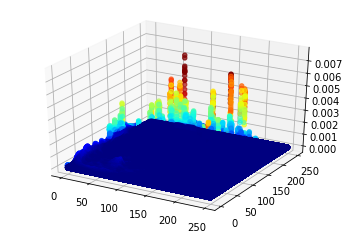

In [25]:
max_sampling = sampling_method(input_data, 1, 'max')
print(max_sampling.shape)
#print(max_sampling)
X = np.repeat(np.arange(0, 250).reshape(1,250), 250, axis=0)
Y = np.repeat(np.arange(0, 250).reshape(250, 1), 250, axis=1)
#tras = np.load('drive/MyDrive/Colab Notebooks/PRECIPf48-level1.npy')
fig = plt.figure()
ax_t = fig.gca(projection='3d')
for i in range(max_sampling.shape[0]):
  ax_t.scatter(X, Y, max_sampling[i,:,:], c=max_sampling[i,:,:], cmap='jet')

(50, 250, 250)


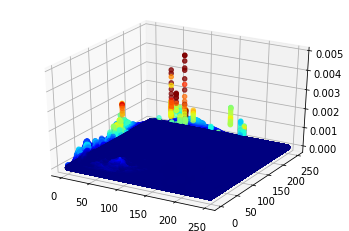

In [26]:
min_sampling = sampling_method(input_data, 1, 'min')
print(min_sampling.shape)
#print(min_sampling)
X = np.repeat(np.arange(0, 250).reshape(1,250), 250, axis=0)
Y = np.repeat(np.arange(0, 250).reshape(250, 1), 250, axis=1)
#tras = np.load('drive/MyDrive/Colab Notebooks/PRECIPf48-level1.npy')
fig = plt.figure()
ax_t = fig.gca(projection='3d')
for i in range(min_sampling.shape[0]):
  ax_t.scatter(X, Y, min_sampling[i,:,:], c=min_sampling[i,:,:], cmap='jet')

(50, 250, 250)


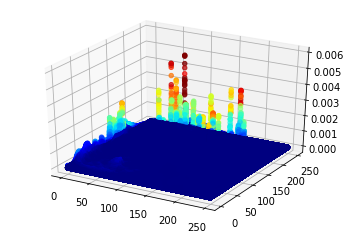

In [27]:
random_sample = random_sampling_method(input_data, 1)
print(random_sample.shape)
X = np.repeat(np.arange(0, 250).reshape(1,250), 250, axis=0)
Y = np.repeat(np.arange(0, 250).reshape(250, 1), 250, axis=1)
#tras = np.load('drive/MyDrive/Colab Notebooks/PRECIPf48-level1.npy')
fig = plt.figure()
ax_t = fig.gca(projection='3d')
for i in range(random_sample.shape[0]):
  ax_t.scatter(X, Y, random_sample[i,:,:], c=random_sample[i,:,:], cmap='jet')

In [28]:
import pywt
def wtTransformation_3d(data, wtType, format, level):
  data = np.array(data).astype(np.float32)
  if(format is 'xyz'):
    store = list()
    for i in range(data.shape[2]):
      store.append(data[:,:,i][np.newaxis,:])
    data = np.vstack(store)
  trans_data = pywt.wavedecn(data, wtType, level=level)[0].astype(np.float32)
  #trans_image = np.array(list(trans_image.values()))[0]
  trans_data = trans_data*((np.max(data)-np.min(data))/(np.max(trans_data)-np.min(trans_data)))
  trans_data = trans_data-(np.min(trans_data)-np.min(data))
  return trans_data

In [29]:
wavelet_sampling = wtTransformation_3d(input_data, 'haar', 'zxy', 1)
print(wavelet_sampling.shape)

(50, 250, 250)


In [33]:
X = np.repeat(np.arange(0, 500).reshape(1,500), 500, axis=0)

In [34]:
Y = np.repeat(np.arange(0, 500).reshape(500, 1), 500, axis=1)

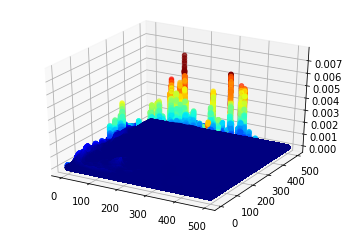

In [45]:
fig_o = plt.figure()
ax = fig_o.gca(projection='3d')
for i in range(100):
  ax.scatter(X, Y, input_data[i,:,:], c=input_data[i,:,:], cmap='jet')

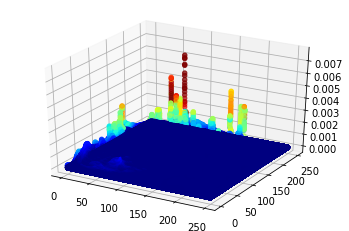

In [75]:
X = np.repeat(np.arange(0, 250).reshape(1,250), 250, axis=0)
Y = np.repeat(np.arange(0, 250).reshape(250, 1), 250, axis=1)
#tras = np.load('drive/MyDrive/Colab Notebooks/PRECIPf48-level1.npy')
fig = plt.figure()
ax_t = fig.gca(projection='3d')
for i in range(wavelet_sampling.shape[0]):
  ax_t.scatter(X, Y, wavelet_sampling[i,:,:], c=wavelet_sampling[i,:,:], cmap='jet')

In [30]:
print(np.max(input_data))
print(np.min(input_data))
print(np.max(wavelet_sampling))
print(np.min(wavelet_sampling))

0.007505861
0.0
0.007505861
0.0


In [32]:
print(wavelet_sampling[np.where((wavelet_sampling<1.5e-38) & (wavelet_sampling>1.5e-40))])

[4.7471648e-39 1.9635849e-39 1.1353561e-38 1.3801918e-38]


In [33]:
print(input_data[np.where((input_data<1.5e-38) & (input_data>1.5e-40))])

[1.2860544e-38 1.2371277e-38 1.4216002e-38 1.2286850e-38 1.3829534e-38
 1.2188019e-38 1.2062987e-38 1.3284954e-38 1.3279560e-38 1.1858001e-38
 1.3860858e-38 1.4132068e-38 1.3821915e-38 1.4397748e-38]


In [34]:
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Maxlevel1', max_sampling)
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Minlevel1', min_sampling)
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Randomlevel1', random_sample)
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Waveletlevel1', wavelet_sampling)

In [39]:
max_sampling = sampling_method(input_data, 2, 'max')
min_sampling = sampling_method(input_data, 2, 'min')
random_sampling = random_sampling_method(input_data, 2)
wavelet_sampling = wtTransformation_3d(input_data, 'haar', 'zxy', 2)
print(max_sampling.shape)
print(min_sampling.shape)
print(random_sampling.shape)
print(wavelet_sampling.shape)

(25, 125, 125)
(25, 125, 125)
(25, 125, 125)
(25, 125, 125)


In [40]:
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Maxlevel2', max_sampling)
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Minlevel2', min_sampling)
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Randomlevel2', random_sampling)
np.save('drive/MyDrive/Colab Notebooks/PRECIPf48-Waveletlevel2', wavelet_sampling)